# Reading 15 million reviews 

*what is the best way to read 15 million reviews?* 

In [1]:
import gzip 
import json
import os

import pandas as pd

In [2]:
DIR = "./data"

In [3]:
def format_data(file_name, head=3_000_000):
    # 15739967
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            print(d)
            count += 1
            
            # only get review_text and review_stars
            data.append([d['review_text'], d['n_votes'], d['rating']])
            # break if reaches the headth line
            if (head is not None) and (count > head):
                break
    return data

In [4]:

# reviews = pd.DataFrame(format_data(os.path.join(
#     DIR, "goodreads_reviews_dedup.json.gz"))
# )

reviews = pd.read_csv("data/sample.csv")
reviews.columns = ["review_text", "n_votes", "rating"]

In [5]:
reviews

,review_text,n_votes,rating
0,Mind blowingly cool. Best science fiction I've...,16,5
1,This is a special book. It started slow for ab...,28,5
2,I haven't read a fun mystery book in a while a...,6,3
3,"Fun, fast paced, and disturbing tale of murder...",22,4
4,A fun book that gives you a sense of living in...,8,4
...,...,...,...
9996,"It still works, but like an 18th century steam...",0,5
9997,Devastating. I was surprised to read that when...,1,5
9998,It was no time to play. It was no time for fun...,2,4
9999,The lesson here is that you cannot know whethe...,1,2


In [6]:
reviews.to_csv(os.path.join(DIR, "sample.csv"), index=False)

Reading 15 million reviews is a challenging task. The reviews are stored in a compressed file, and the file is too large to fit into memory. 

So for now we will read a small subset of the reviews, with the maximum we can extract being 3 million reviews. So an alternate approach is to read the reviews in chunks. 

In this notebook, we will read the reviews in chunks and process them.

# EDA

In [7]:
import nltk

from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import FreqDist

import string

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [8]:
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessedoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Keeping review text as the main focus, but also keeping track of number of votes and ratings, may also be useful. 

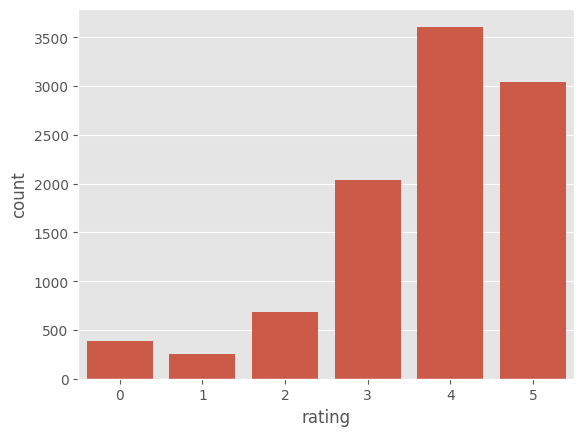

In [9]:
ax = sns.countplot(data=reviews, x='rating')

In [10]:
example = reviews.iloc[55]['review_text']
print(example)

A wonderful, beautifully written, poignant, subtle, and brilliant novel. 
 This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end. It is ultimately a story of regret. It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back. One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework. 
 But what I really loved about the novel is how slow and forcefully it builds. I don't think I've read a book that does that so well since Pride and Prejudice. In the beginning you think it's just a butler going on a motoring trip. And at the end, your heart is breaking. 
 Dignity is a big theme in the novel. Stevens attempts to define dignity several times throughout the novel - his definition generally has to do with self-respect and keeping on

In [11]:
sentences = sent_tokenize(example)

This way we can look at specific tokens within each sentence and see how they are distributed. 

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def extract_sentiment_terms(sentence):
    # Tokenize words and tag part of speech
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    sentiment_terms = set()

    for word, tag in tagged_words:
        if word.lower() not in stop_words and word not in string.punctuation:
            if tag.startswith('JJ') or tag.startswith('RB'):
                if word.lower() in opinion_lexicon.positive() or word.lower() in opinion_lexicon.negative():
                    sentiment_terms.add(word)

    return sentiment_terms


In [14]:
sentiment_terms = set()
for sentence in sentences:
    sentiment_terms.update(extract_sentiment_terms(sentence))

Huang, S., Niu, Z., & Shi, C. (2014). Automatic construction of domain-specific sentiment lexicon based on constrained label propagation. Knowledge-Based Systems, 56, 191–200. https://doi.org/10.1016/j.knosys.2013.11.009

Shows that we can extract sentiment terms from tokenised sentences by identifing adjectives (JJ) and adverbs (RB) that are close to the sentiment term.

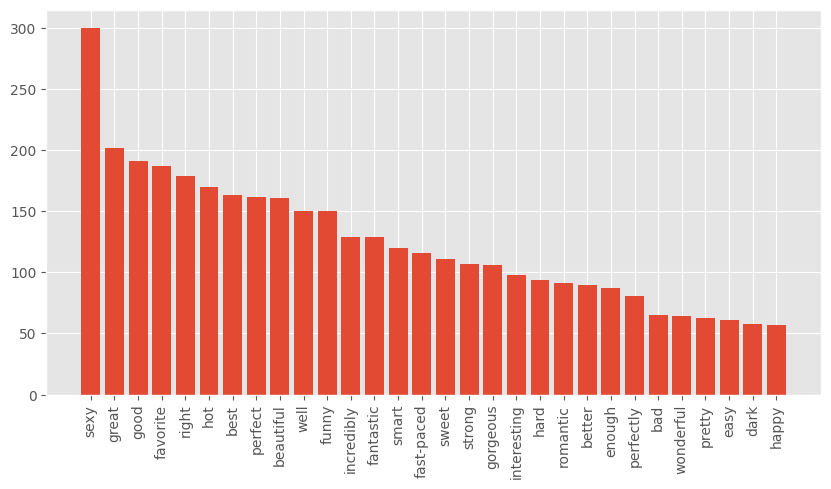

In [15]:
# frequency distribution of words 

processed_reviews = []
for review in reviews['review_text'][:1000]:
    if isinstance(review, str):  # Check if review is a string
        processed_reviews.extend(extract_sentiment_terms(review))

freq_dist = FreqDist(processed_reviews)

# Get the 30 most common words
common_words = freq_dist.most_common(30)

# Unzip the list of tuples into two lists
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation='vertical')
plt.show()

when looking at the distribution of the sentiment terms, we can see that the sentiment, as we can see words with positive sentiment are more common than negative sentiment words, and this also corralates with the ratings of the reviews.

In [16]:
sentiment_terms = list(sentiment_terms)
sentiment_terms

['well',
 'poignant',
 'favorite',
 'best',
 'fond',
 'wonderful',
 'beautifully',
 'brilliant',
 'slow',
 'great',
 'Good',
 'self-respect',
 'better',
 'interesting',
 'hard']

From each sentence we have extracted the sentiment terms, from each sentence and now is in the form of a list. 

Now we can apply this function to all the reviews in our dataset.

In [17]:
from gensim.models import Word2Vec

In [18]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

In [19]:
def learn_word_embeddings(processed_corpus):
    # Train a Word2Vec model on the processed corpus
    model = Word2Vec(sentences=processed_corpus,
                     vector_size=100, window=5, min_count=1, workers=4)
    return model       

In [20]:
model = learn_word_embeddings([word_tokenize(word) for word in sentences])

for token in sentiment_terms:
    if token in model.wv:
        print(f"{token}: {model.wv.most_similar(token)}")
    else:
        synonyms = get_synonyms(token)

        for synonym in synonyms:
            if synonym in model.wv:
                print(f"{synonym}: {model.wv.most_similar(synonym)}")

well: [('communicate', 0.28808584809303284), ('quotes', 0.25321972370147705), ('somewhere', 0.24334941804409027), ('at', 0.2346959412097931), ('multi-day', 0.23401068150997162), ("'dignity", 0.22720478475093842), ('Pride', 0.2154659926891327), ('great', 0.20051124691963196), ('Jeff', 0.20006614923477173), ('instance', 0.19325153529644012)]
poignant: [('stays', 0.3171199560165405), (';', 0.31636252999305725), ('done', 0.28950604796409607), ('slow', 0.2707963287830353), ('suppression', 0.207774356007576), ('from', 0.20471633970737457), ('quotes', 0.19958971440792084), ('realizes', 0.19664467871189117), ('value', 0.19638633728027344), ('somewhere', 0.19119834899902344)]
favorite: [('In', 0.2623365819454193), ('look', 0.2601579427719116), ('back', 0.2346973419189453), ('Bezos', 0.2192993313074112), ('directness', 0.2123260349035263), ('I', 0.21137048304080963), ('tiger', 0.20688234269618988), ('live', 0.195384681224823), ('my', 0.19369935989379883), ('how', 0.18808841705322266)]
best: [('r

By tokenising each word in the sentence we can also find similar word pairs that are close to the sentiment term. Using `get_synonyms` we can find similar words to the sentiment term using the WordNet corpus.

This can be expanded upon by providing a larger dataset to train on.

#### Approach

1. Read the reviews in chunks
2. Tokenize the reviews and process sentences
3. Extract sentiment terms
4. Extract similar word pairs
5. Train a model on the processesd_corpus



# Trait Dataset

In [21]:
essays = pd.read_csv('data/essays.csv')

## Preprocessing

In [22]:
essays = essays.rename(columns={
    'TEXT': 'text',
    'cEXT': 'extroversion',
    'cNEU': 'neuroticism',
    'cAGR': 'agreeableness',
    'cCON': 'conscientiousness',
    'cOPN': 'openness'
})

# subset the data text + big five

essays = essays[['text', 'extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']]

# convert n and y to 0 and 1
essays = essays.replace({'n': 0, 'y': 1})

/var/folders/lg/qth2myc91gj4tfy56qzfn3b40000gn/T/ipykernel_82641/1694335583.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  essays = essays.replace({'n': 0, 'y': 1})


In [23]:
essays

,text,extroversion,neuroticism,agreeableness,conscientiousness,openness
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,I can't believe it! It's really happening! M...,1,0,1,1,0
4,"Well, here I go with the good old stream of co...",1,0,1,0,1
...,...,...,...,...,...,...
2462,I'm home. wanted to go to bed but remembe...,0,1,0,1,0
2463,Stream of consiousnesssskdj. How do you s...,1,1,0,0,1
2464,"It is Wednesday, December 8th and a lot has be...",0,0,1,0,0
2465,"Man this week has been hellish. Anyways, now i...",0,1,0,0,1


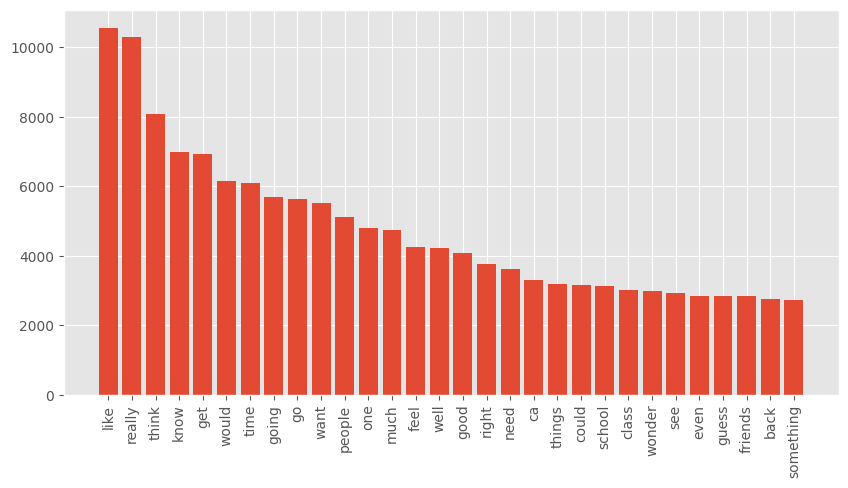

In [24]:
processed_essays = []
for essay in essays['text']:
    words = word_tokenize(essay)
    processed_essays.extend([word.lower() for word in words if word.isalpha() and word.lower() not in stop_words])

freq_dist = FreqDist(processed_essays)

# Get the 30 most common words
common_words = freq_dist.most_common(30)

# Unzip the list of tuples into two lists
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation='vertical')
plt.show()

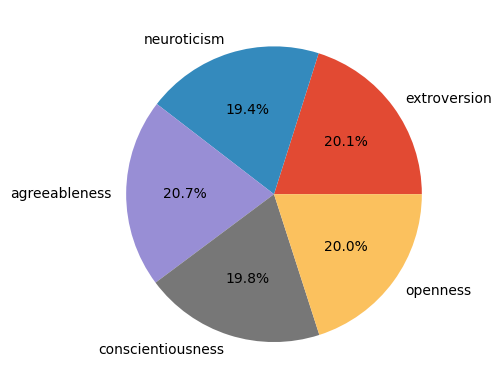

In [25]:
categories = ['extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

counts = [essays[category].sum() for category in categories]

plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.show()

All traits represent around 20% of the total dataset. The traits are extracted from the reviews and are used to train the model.

In [26]:
essays.to_pickle('data/essays-preprocessed.pkl')

## Training the model

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from preprocessing import preprocess_text
from tqdm import tqdm
import pandas as pd
import joblib

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessedoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [28]:
tqdm.pandas()

def load_data(file_path):
    # Load Pickled data
    df = pd.read_pickle(file_path)

    df['preprocessed_text'] = df['text'].progress_apply(lambda x: ' '.join(map(str, preprocess_text(x)))) # type: ignore

    return df

In [29]:
def evaluate_model(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [30]:
def train_model(df, target_columns, model, model_path):

    X = df['preprocessed_text']
    y = df[target_columns]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)

    if model_path is not None:
        joblib.dump(model, model_path)

    # datafrmae to store the results
    results = pd.DataFrame({
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })

    return model, results

In [31]:
def predict(model, test_sentence):
    # Preprocess the text
    test_sentence_processed = preprocess_text(test_sentence)
    test_sentence_processed = ' '.join(map(str, test_sentence_processed)) # type: ignore

    # Predicting with each model
    return model.predict([test_sentence_processed])
    

In [32]:
def predict_and_concatenate(models, test_sentence):
    predictions = []
    for model in models:
        
        # Preprocess the text
        test_sentence_processed = preprocess_text(test_sentence)
        test_sentence_processed = ' '.join(map(str, test_sentence_processed)) # type: ignore

        # Predicting with each model
        pred = model[1].predict([test_sentence_processed])
        
        # Assuming binary classification, ensuring binary output (0 or 1)
        predictions.append(pred)
    
    # Transposing to get predictions for each sample across all models
    predictions_per_sample = list(zip(*predictions))

    # Concatenating binary predictions for each sample into a single string
    concatenated_predictions = [''.join(map(str, sample_preds)) for sample_preds in predictions_per_sample]

    return concatenated_predictions

In [33]:
# df = load_data('data/essays.pkl')

In [34]:
df = pd.read_pickle('data/essays_preprocessed.pkl')

In [35]:
df['preprocessed_text']

0       ['well', ',', 'right', 'woke', 'mid-day', 'nap...
1       ['well', ',', 'go', 'stream', 'consciousness',...
2       ['open', 'keyboard', 'buttons', 'push', '.', '...
3       ['ca', "n't", 'believe', '!', "'s", 'really', ...
4       ['well', ',', 'go', 'good', 'old', 'stream', '...
                              ...                        
2462    ["'m", 'home', '.', 'wanted', 'go', 'bed', 're...
2463    ['stream', 'consiousnesssskdj', '.', 'spell', ...
2464    ['wednesday', ',', 'december', '8th', 'lot', '...
2465    ['man', 'week', 'hellish', '.', 'anyways', ','...
2466    ['gotten', 'phone', 'brady', '.', "'m", 'tryin...
Name: preprocessed_text, Length: 2467, dtype: object

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

In [37]:
traits = ['extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

### Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
])

In [40]:
lr_model = train_model(df, traits, model, None)
lr_model[1]

,accuracy,precision,recall,f1
0,0.072874,0.592626,0.625866,0.60797


In [41]:
predict(lr_model[0], 'You')

array([[1, 0, 0, 0, 1]])

In [42]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

train_model(df, traits, grid_search, None)[1]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,accuracy,precision,recall,f1
0,0.072874,0.595379,0.628945,0.610679


In [43]:
predict(grid_search, 'You')

array([[1, 0, 0, 0, 1]])

#### Multi Model Approach

In [44]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

In [45]:
lr_models = []
lr_metrics = []

for t in traits:
    model, metrics = train_model(df, t, model, None)
    print(f'Training model for {t}') 
    print(metrics) 
    lr_models.append((t, model))
    lr_metrics.append((t, metrics)) 

Training model for extroversion
   accuracy  precision   recall        f1
0   0.55668    0.55543  0.55668  0.555871
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.591093   0.595816  0.591093  0.590637
Training model for agreeableness
   accuracy  precision    recall       f1
0  0.564777   0.557906  0.564777  0.55704
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.558704   0.559926  0.558704  0.559169
Training model for openness
   accuracy  precision    recall        f1
0  0.609312    0.60952  0.609312  0.609393


In [46]:
predict_and_concatenate(lr_models, 'I am a very happy person')

['11111']

In [47]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10]  # Corrected parameter
}

# Update the model in GridSearchCV to the pipeline model
grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

for t in traits:
    model, metrics = train_model(df, t, grid_search, None)
    print(f'Training model for {t}') 
    print(metrics) 
    lr_models.append((t, model))
    lr_metrics.append((t, metrics))  

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Training model for extroversion
   accuracy  precision    recall        f1
0  0.560729   0.559758  0.560729  0.560131
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.609312   0.622196  0.609312  0.605559
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for agreeableness
   accuracy  precision   recall        f1
0   0.58502   0.577897  0.58502  0.565757
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.580972    0.57735  0.580972  0.575112
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for openness
   accuracy  precision    recall        f1
0  0.619433    0.62712  0.619433  0.617331


### SVM

In [48]:
from sklearn.svm import LinearSVC

In [49]:
# svm
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(dual=True)))
])

In [50]:
svm_model = train_model(df, traits, model, None)
svm_model[1]

,accuracy,precision,recall,f1
0,0.068826,0.587285,0.575058,0.57975


In [51]:
predict(svm_model[0], 'You')

array([[1, 0, 0, 1, 1]])

Using OneVsRestClassifier is a simple way to train a multi-label classification model.

But its performance is not good enough. with accuracy of 0.07. 

In [52]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(dual=True))
])

In [53]:
svm_models = []
svm_metrics = []

for t in traits:
    model, metrics = train_model(df, t, model, None)
    print(f'Training model for {t}') 
    print(metrics) 
    svm_models.append((t, model))
    svm_metrics.append((t, metrics))


Training model for extroversion
   accuracy  precision    recall       f1
0  0.552632   0.556839  0.552632  0.55332
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.560729   0.566311  0.560729  0.559621
Training model for agreeableness
   accuracy  precision   recall        f1
0   0.54251   0.541299  0.54251  0.541825
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.558704    0.56162  0.558704  0.559422
Training model for openness
   accuracy  precision    recall        f1
0  0.593117   0.595748  0.593117  0.592909


In [54]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

svm_models = []
svm_metrics = []

for t in traits:
    model, metrics = train_model(df, t, grid_search, None)
    print(f'Training model for {t}') 
    print(metrics) 
    svm_models.append((t, model))
    svm_metrics.append((t, metrics))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for extroversion
   accuracy  precision    recall        f1
0  0.554656   0.552504  0.554656  0.552999
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.609312   0.625127  0.609312  0.604154
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for agreeableness
   accuracy  precision    recall        f1
0  0.574899    0.56779  0.574899  0.530713
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.580972   0.578438  0.580972  0.578442
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for openness
   accuracy  precision    recall        f1
0  0.615385   0.621015  0.615385  0.614122


In [55]:
predict_and_concatenate(svm_models, 'I am a very happy person')

['11111']

### Random Forest Classifier 

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [58]:
rf_models = []
rf_metrics = []

for t in traits:
    model, metrics = train_model(df, t, model, None)
    print(f'Training model for {t}') 
    print(metrics) 
    rf_models.append((t, model))
    rf_metrics.append((t, metrics))

Training model for extroversion
   accuracy  precision    recall        f1
0  0.522267   0.518007  0.522267  0.518468
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.538462   0.538866  0.538462  0.538628
Training model for agreeableness
   accuracy  precision    recall        f1
0  0.562753   0.551328  0.562753  0.539297
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.526316   0.526946  0.526316  0.526597
Training model for openness
   accuracy  precision    recall        f1
0  0.574899   0.577551  0.574899  0.574627


In [59]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

rf_models = []
rf_metrics = []

for t in traits:
    model, metrics = train_model(df, t, grid_search, None)
    print(f'Training model for {t}') 
    print(metrics) 
    rf_models.append((t, model))
    rf_metrics.append((t, metrics))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for extroversion
   accuracy  precision    recall        f1
0  0.560729   0.554882  0.560729  0.547862
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for neuroticism
   accuracy  precision    recall        f1
0  0.578947   0.582487  0.578947  0.578851
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for agreeableness
   accuracy  precision    recall       f1
0  0.568826   0.560494  0.568826  0.51128
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for conscientiousness
   accuracy  precision    recall        f1
0  0.578947   0.575196  0.578947  0.572837
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for openness
   accuracy  precision    recall        f1
0  0.611336   0.615652  0.611336  0.610577


In [60]:
predict_and_concatenate(rf_models, 'I am a very happy person')

['11111']

## BERT Model 

In [61]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Split data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df["preprocessed_text"], df[traits], test_size=0.2, random_state=42)


/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)



In [63]:
class PersonalityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PersonalityDataset(train_encodings, train_labels)
val_dataset = PersonalityDataset(val_encodings, val_labels)

In [64]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df[traits].columns))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  0%|          | 1/741 [04:33<56:09:46, 273.23s/it]

In [ ]:
trainer.evaluate()

# LIWC classification

In [ ]:
import liwc

parse, category_name = liwc.load_token_parser('data/LIWC2007_English100131.dic')

In [ ]:
# LIWC 2007
from nltk.tokenize import word_tokenize

sentences = '''i care about you abdomen'''
tokens = word_tokenize(sentences.lower())

# List of lists of categories for each token
matches = {token : [category for category in parse(token)] for token in tokens}
matches

{'i': ['funct', 'pronoun', 'ppron', 'i'],
 'care': ['verb', 'present', 'affect', 'posemo'],
 'about': ['funct', 'adverb', 'preps'],
 'you': ['funct', 'pronoun', 'ppron', 'you', 'social'],
 'abdomen': ['bio', 'body']}

Words that do not appear in the LIWC dictionary are not identified. 

The LIWC dictionary is not perfect, but it is a good starting point, and it is easy to use.

One Solution is to use the LIWC dictionary to identify the words that are not in the dictionary, and then use a different method to identify the words that are not in the dictionary, such as another classification model. 

In [ ]:
# parse every word in LIWC2007_English100131.dic
from liwc import read_dic
from collections import defaultdict

lexicon, category_names = read_dic('data/LIWC2007_English100131.dic')

len(lexicon)

4484

In [ ]:
# create a dataframe to store the lexicon (word, category)

liwc_lexicon = defaultdict(list)
for word, categories in lexicon.items():
    liwc_lexicon['word'].append(word_tokenize(word)[0])
    liwc_lexicon['categories'].append(categories)

liwc_lexicon = pd.DataFrame(liwc_lexicon)

liwc_lexicon.head()
liwc_lexicon.to_csv('data/liwc_lexicon.csv', index=False)

In [ ]:
liwc_lexicon = defaultdict(list)
for word, categories in lexicon.items():
    liwc_lexicon['preprocessed_text'].append(word_tokenize(word)[0])
    for category in category_names:
        liwc_lexicon[category].append(int(category in categories))

liwc_lexicon = pd.DataFrame(liwc_lexicon)

liwc_lexicon.head()

,preprocessed_text,funct,pronoun,ppron,i,we,you,shehe,they,ipron,...,work,achieve,leisure,home,money,relig,death,assent,nonfl,filler
0,a,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abandon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abdomen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abilit,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,able,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
liwc_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(dual=True))
])

In [ ]:
liwc_models = []
liwc_metrics = []

for i in category_names:
    model, metrics = train_model(liwc_lexicon, i, liwc_model, None)
    print(f'Training model for {i}')
    print(metrics)
    liwc_models.append((i, model))
    liwc_metrics.append((i, metrics))

Training model for funct
   accuracy  precision    recall       f1
0  0.911929   0.915271  0.911929  0.88497
Training model for pronoun
   accuracy  precision    recall        f1
0  0.982163   0.980692  0.982163  0.978332
Training model for ppron
   accuracy  precision    recall       f1
0  0.989967   0.989061  0.989967  0.98846
Training model for i
   accuracy  precision   recall        f1
0   0.99777   0.995546  0.99777  0.996657
Training model for we
   accuracy  precision   recall        f1
0   0.99777   0.997775  0.99777  0.997214
Training model for you
   accuracy  precision    recall        f1
0  0.998885   0.998886  0.998885  0.998774
Training model for shehe
   accuracy  precision    recall        f1
0  0.998885   0.998886  0.998885  0.998774
Training model for they
   accuracy  precision    recall        f1
0  0.996656   0.996286  0.996656  0.996418
Training model for ipron
   accuracy  precision    recall        f1
0  0.992196   0.992257  0.992196  0.989177
Training model fo

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Training model for preps
   accuracy  precision    recall        f1
0  0.985507   0.971225  0.985507  0.978314
Training model for conj
   accuracy  precision    recall        f1
0  0.991081   0.982242  0.991081  0.986642
Training model for negate
   accuracy  precision    recall        f1
0  0.983278   0.973379  0.983278  0.978303
Training model for quant
   accuracy  precision    recall        f1
0  0.978818   0.958085  0.978818  0.968341
Training model for number
   accuracy  precision    recall        f1
0  0.993311   0.986667  0.993311  0.989978
Training model for swear
   accuracy  precision    recall        f1
0  0.989967   0.980034  0.989967  0.984975
Training model for social
   accuracy  precision    recall        f1
0  0.914158   0.921661  0.914158  0.885799
Training model for family
   accuracy  precision    recall        f1
0  0.983278   0.983558  0.983278  0.977376
Training model for friend
   accuracy  precision    recall        f1
0  0.993311   0.986667  0.993311  0.9899

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Training model for insight
   accuracy  precision    recall        f1
0  0.956522   0.914934  0.956522  0.935266
Training model for cause
   accuracy  precision    recall        f1
0  0.966555   0.934229  0.966555  0.950117
Training model for discrep
   accuracy  precision    recall        f1
0  0.982163   0.982482  0.982163  0.976298
Training model for tentat
   accuracy  precision  recall        f1
0    0.9699   0.940705  0.9699  0.955079
Training model for certain
   accuracy  precision    recall        f1
0  0.982163   0.982481  0.982163  0.974315
Training model for inhib
   accuracy  precision    recall        f1
0  0.974359   0.949375  0.974359  0.961705
Training model for incl
   accuracy  precision    recall        f1
0  0.995541   0.991101  0.995541  0.993316
Training model for excl
   accuracy  precision    recall        f1
0  0.996656   0.993322  0.996656  0.994986
Training model for percept
   accuracy  precision    recall       f1
0  0.958751   0.960455  0.958751  0.93962


/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Training model for relativ
   accuracy  precision    recall      f1
0  0.848384   0.871397  0.848384  0.7799
Training model for motion
   accuracy  precision    recall        f1
0  0.953177   0.908547  0.953177  0.930327
Training model for space
   accuracy  precision    recall        f1
0  0.950948   0.953356  0.950948  0.928105
Training model for time
   accuracy  precision    recall        f1
0  0.946488    0.89584  0.946488  0.920468
Training model for work
   accuracy  precision    recall        f1
0  0.929766   0.864465  0.929766  0.895927
Training model for achieve
   accuracy  precision    recall        f1
0  0.949833   0.902182  0.949833  0.925395
Training model for leisure
   accuracy  precision    recall        f1
0  0.955407   0.912802  0.955407  0.933619
Training model for home
   accuracy  precision    recall        f1
0  0.976589   0.953725  0.976589  0.965022
Training model for money
   accuracy  precision    recall       f1
0  0.960981   0.923485  0.960981  0.94186
Tra

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
predict_and_concatenate(liwc_models, 'i care about you abdomen')

['0000000000000000000000000000000000000000000000000000000000000000']